In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

In [2]:
import util as util

[nltk_data] Downloading package punkt to /home/bindra.p/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bindra.p/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bindra.p/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# get word embeddings from the gensim package
import gensim.downloader

# download the glove embeddings
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [4]:
TRAIN_PATH = '../dataset/SciHTC/train_title_abstract_keywords.csv'
TEST_PATH = '../dataset/SciHTC/test_title_abstract_keywords.csv'
DEV_PATH = '../dataset/SciHTC/dev_title_abstract_keywords.csv'

# TRAIN_PATH = '/home/bindra.p/cs6140/Datasets/SciHTC/train_title_abstract_keywords.csv'
# TEST_PATH = '/home/bindra.p/cs6140/Datasets/SciHTC/test_title_abstract_keywords.csv'
# DEV_PATH = '/home/bindra.p/cs6140/Datasets/SciHTC/dev_title_abstract_keywords.csv'

In [5]:
MAX_LEN = 500
EMBEDDING_DIM = 50
# SAMPLE_SIZE = 18000

In [6]:
# read train and test data
train_df = util.read_data(TRAIN_PATH)
test_df = util.read_data(TEST_PATH)

input_cols = ['Title', 'Abstract']

# process the data and sample some for testing; it changes to df in place.
# Reload df if running again
train_df = util.preprocess_data(train_df, input_cols, 'Keywords', sample_size=None)
test_df = util.preprocess_data(test_df, input_cols, 'Keywords', sample_size=None)
# test_df = util.preprocess_data(test_df, input_cols, 'Keywords')

# set up the tokenizer
tokenizer = util.setup_tokenizer(train_df, test_df, ['input_tokens', 'clean_kp'])

# create embeddings matrix
embeddings_matrix = util.get_embeddings_matrix(tokenizer, glove_vectors, EMBEDDING_DIM)

# create the input array
X_train, y_train = util.create_input_array(train_df, 'input_tokens', 'clean_kp', tokenizer,
                                           embeddings_matrix, EMBEDDING_DIM, MAX_LEN)

X_test, y_test = util.create_input_array(test_df, 'input_tokens', 'clean_kp', tokenizer,
                                            embeddings_matrix, EMBEDDING_DIM, MAX_LEN)


In [8]:
print("embeddings_matrix shape:", embeddings_matrix.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("Number of words in the vocabulary:", len(tokenizer.word_index))

# find the max length of the input sequences
max_length = max([len(seq) for seq in train_df['input_tokens']])
print("original samples max length:", max_length)

embeddings_matrix shape: (436619, 50)
X_train shape: (148928, 500, 50)
y_train shape: (148928, 500)
X_test shape: (18616, 500, 50)
y_test shape: (18616, 500)
Number of words in the vocabulary: 436619
original samples max length: 811


In [16]:
# build bi-LSTM model
model = Sequential()

# Shujun
# model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(MAX_LEN, EMBEDDING_DIM)))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(MAX_LEN, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.3), input_shape=(MAX_LEN, EMBEDDING_DIM)))
model.add(Bidirectional(LSTM(32, dropout=0.2)))
model.add(Dense(MAX_LEN, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 500, 64)           21248     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 500)               32500     
                                                                 
Total params: 78580 (306.95 KB)
Trainable params: 78580 (306.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# fit model
model_data = model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
4654/4654 [==============================] - 1143s 244ms/step - loss: 0.0915 - accuracy: 0.1778
Epoch 2/5
4654/4654 [==============================] - 1121s 241ms/step - loss: 0.0816 - accuracy: 0.1815
Epoch 3/5
4654/4654 [==============================] - 1117s 240ms/step - loss: 0.0795 - accuracy: 0.1869
Epoch 4/5
4654/4654 [==============================] - 1114s 239ms/step - loss: 0.0790 - accuracy: 0.2016
Epoch 5/5
4654/4654 [==============================] - 1114s 239ms/step - loss: 0.0786 - accuracy: 0.2068


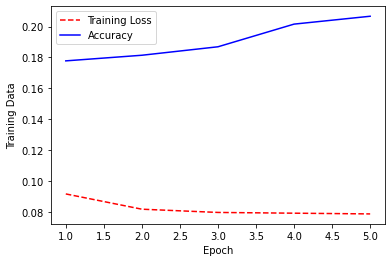

In [18]:
loss = model_data.history['loss']
acc = model_data.history['accuracy']
epoch_count = range(1, len(loss) + 1)

# Visualize graph
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, acc, 'b-')
plt.legend(['Training Loss', 'Accuracy'])
plt.xlabel('Epoch')  
plt.ylabel('Training Data')
plt.show()

In [19]:
model.save('/home/bindra.p/cs6140/bi_lstm_model_3')

INFO:tensorflow:Assets written to: /home/bindra.p/cs6140/bi_lstm_model_3/assets


INFO:tensorflow:Assets written to: /home/bindra.p/cs6140/bi_lstm_model_3/assets


In [ ]:
# testing prediction
preds = model.predict(X_test)

print(len(preds))
print(preds)

# print prediction
pred_kws = util.pred_to_keywords(preds, test_df['input_tokens'].values)
print(pred_kws)